In [31]:
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import rdflib
import re
from tqdm import tqdm
import numpy as np

## Analyse training

In [32]:
files = glob("analysis/results/*.json")
df = None

for f in files:
  f_data = json.load(open(f))
  series = pd.Series()

  model, degree, _, _ = f.split(".")
  degree = ''.join([char for char in degree if char.isdigit()])
  series["degree"] = int(degree) + 1
  series["model"] = model

  #series["train_losses"] = f_data["train_losses"]
  #series["train_loss"] = f_data["train_losses"][-1] if len(series["train_losses"]) > 0 else -1

  #series["test_losses"] = f_data["test_losses"]
  #series["test_loss"] = f_data["test_losses"][-1] if len(series["test_losses"]) > 0 else -1

  for rel, val in f_data["relationship_weights"].items():
    series[rel] = val


  metrics = {k: [m[k] for m in f_data["metrics"]] for k in f_data["metrics"][0].keys()}
  #series["metrics"] = metrics

  for k, v in metrics.items():
    series[k] = max(v) #[-1]

  series = series.to_frame().T
  if df is None:
    df = series
  else:
    df = pd.concat([df, series])

df.columns = [c.replace("@None", "") for c in df.columns]

In [33]:
x_labels = ["Learned", "freq", "freq$^{-1}$", 1]
df_model = ['analysis/results/fit', 'analysis/results/frequency', 'analysis/results/inverse-frequency', 'analysis/results/uniform']

In [34]:
df

,degree,model,http://w3id.org/friendshipneverends/ontology/hasFriend,http://w3id.org/friendshipneverends/ontology/hasAcquaintance,http://w3id.org/friendshipneverends/ontology/hasBandmate,http://w3id.org/friendshipneverends/ontology/hasMentor,http://w3id.org/friendshipneverends/ontology/hasAdmirator,http://w3id.org/friendshipneverends/ontology/hasPupil,H,MRR,...,MAP@20,DCG@20,H@50,MRR@50,MAP@50,DCG@50,H@100,MRR@100,MAP@100,DCG@100
0,3,analysis/results/frequency,0.030037,0.788355,0.101895,0.021835,0.036044,0.021835,1.0,0.093318,...,0.078059,0.081746,0.866667,0.091474,0.097058,0.175199,1.0,0.093318,0.092752,0.276599
0,2,analysis/results/frequency,0.030037,0.788355,0.101895,0.021835,0.036044,0.021835,1.0,0.599136,...,0.453968,0.517202,1.0,0.599136,0.429287,0.597425,1.0,0.599136,0.426517,0.641649
0,5,analysis/results/inverse-frequency,33.292308,1.268464,9.814059,45.798942,27.74359,45.798942,1.0,0.179005,...,0.112336,0.08332,0.866667,0.177986,0.085737,0.154795,0.933333,0.178727,0.079702,0.222302
0,2,analysis/results/frequency,0.030037,0.788355,0.101895,0.021835,0.036044,0.021835,1.0,0.564444,...,0.451914,0.509197,1.0,0.564444,0.451872,0.592182,1.0,0.564444,0.424968,0.617009
0,2,analysis/results/fit,0.747994,-0.374552,0.732629,0.763041,0.765692,0.754726,1.0,0.607143,...,0.562607,0.555188,1.0,0.607143,0.485795,0.625725,1.0,0.607143,0.485795,0.651878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,analysis/results/uniform,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.080218,...,0.061791,0.062402,0.866667,0.077843,0.080124,0.159985,1.0,0.080218,0.08503,0.249208
0,2,analysis/results/uniform,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510897,...,0.457861,0.490573,1.0,0.510897,0.394085,0.598242,1.0,0.510897,0.395735,0.618775
0,3,analysis/results/inverse-frequency,33.292308,1.268464,9.814059,45.798942,27.74359,45.798942,1.0,0.105239,...,0.081327,0.067321,0.933333,0.104164,0.080046,0.167632,1.0,0.105239,0.071552,0.220136
0,3,analysis/results/frequency,0.030037,0.788355,0.101895,0.021835,0.036044,0.021835,1.0,0.063802,...,0.035132,0.046541,0.933333,0.062652,0.068381,0.193996,1.0,0.063802,0.075378,0.284888


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6378/2609422021.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax[idx].set_xlabel(f"$\mu({measure})$")


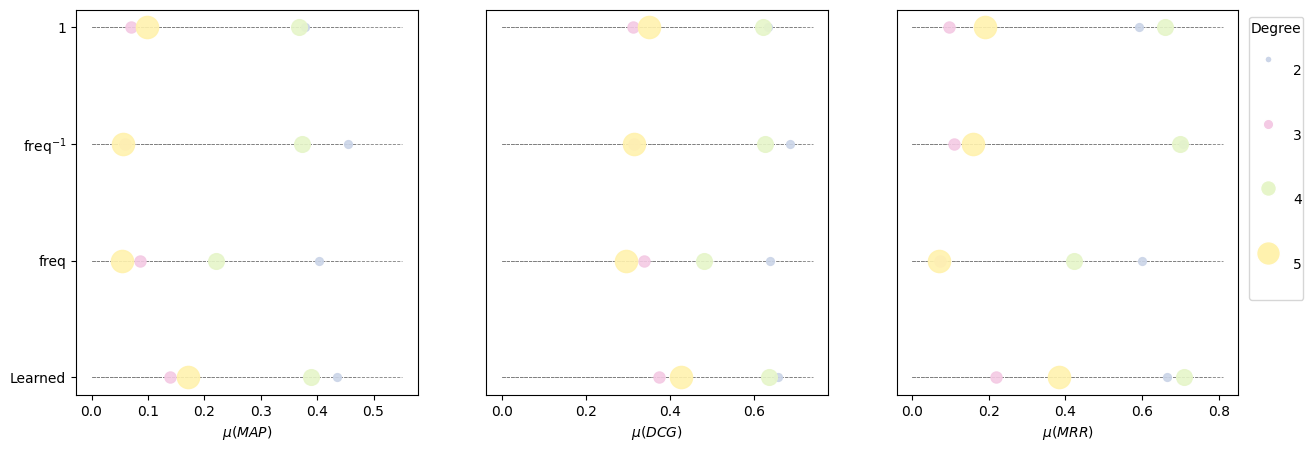

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap = mpl.colormaps["Pastel2"]
x_axis = list(range(len(x_labels)))
degrees = sorted(df.degree.unique())

for model, x in zip(df_model, x_axis):
  model_df = df[df.model == model]
  for degree in degrees:
    for idx, measure in enumerate(["MAP", "DCG", "MRR"]):
      val = model_df[model_df.degree == degree][measure].mean()
      ax[idx].hlines(x, 0, df[df.degree == degree][measure].max(), colors="grey", linestyles="dashed", zorder=-1, linewidths=0.6)
      ax[idx].scatter(val, x, color=cmap(degree), s=2 ** (degree + 3), alpha=0.9)
      ax[idx].set_xlabel(f"$\mu({measure})$")

      if idx == 0:
        ax[idx].set_yticks(x_axis, x_labels)
      else:
        ax[idx].set_yticks([])

legend_elements = [
  mpl.lines.Line2D([0], [0], marker='o', color='w', label=degree, markerfacecolor=cmap(degree), markersize=1.5 ** (degree + 2))
  for degree in degrees
]
ax[-1].legend(handles=legend_elements, bbox_to_anchor=(1.01, 1, 0.2, 0), loc='upper left', mode="expand", title="Degree", handleheight=6)

fig.savefig('figures/degree_performance.png', dpi=300, bbox_inches="tight")

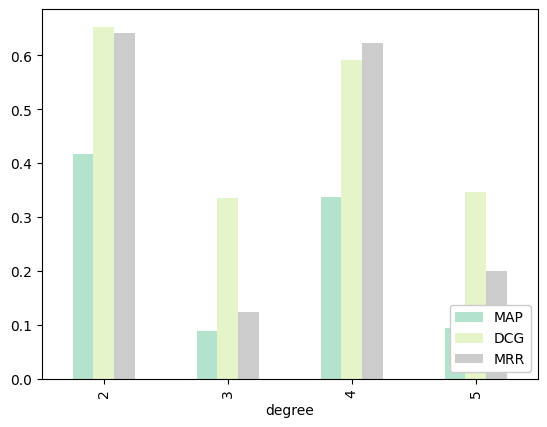

In [36]:
ax = df.groupby(["degree"])[["MAP", "DCG", "MRR"]].mean().plot.bar(cmap="Pastel2")
ax.legend(loc='lower right', framealpha=1)
fig = ax.get_figure()
fig.savefig('figures/degree_plot.png', dpi=300, bbox_inches="tight")

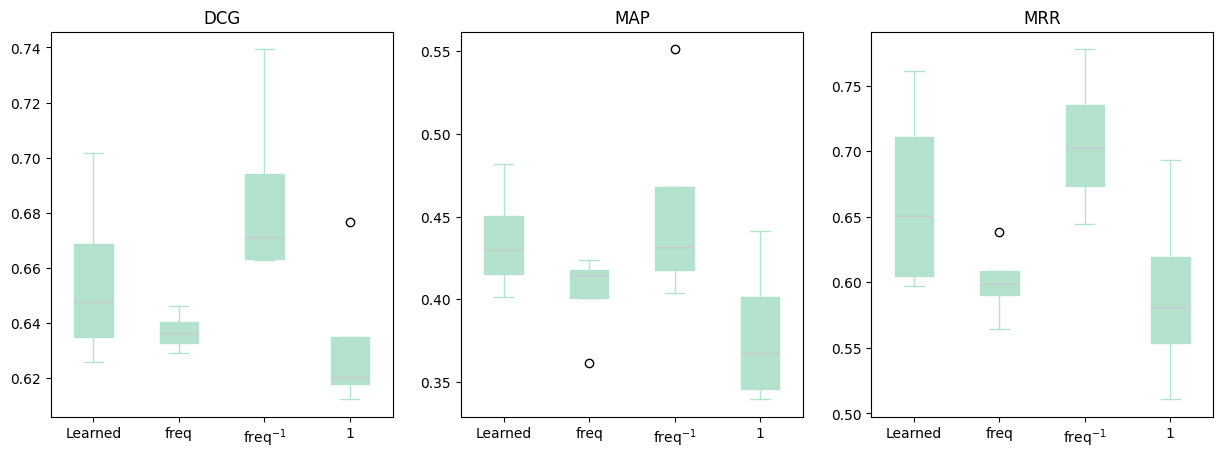

In [38]:
axs = df[df.degree == 2].plot.box(column=["MAP", "DCG", "MRR"], cmap="Pastel2", by="model", figsize=(15, 5), patch_artist=True)

for ax in axs:
  ax.set_xticklabels(["Learned", "freq", "freq$^{-1}$", 1])

fig.savefig('figures/degree_plot.png', dpi=300, bbox_inches="tight")

In [39]:
print(df[df.degree == 2].sort_values(["MAP", "DCG", "MRR"], ascending=False).groupby("model")[["MAP", "DCG", "MRR"]].agg(lambda x: f"${x.mean():1.2f} \pm {x.std():1.2f}$").to_latex())

\begin{tabular}{llll}
\toprule
 & MAP & DCG & MRR \\
model &  &  &  \\
\midrule
analysis/results/fit & $0.44 \pm 0.03$ & $0.66 \pm 0.03$ & $0.66 \pm 0.08$ \\
analysis/results/frequency & $0.40 \pm 0.03$ & $0.64 \pm 0.01$ & $0.60 \pm 0.03$ \\
analysis/results/inverse-frequency & $0.45 \pm 0.07$ & $0.69 \pm 0.04$ & $0.71 \pm 0.06$ \\
analysis/results/uniform & $0.38 \pm 0.05$ & $0.63 \pm 0.03$ & $0.59 \pm 0.08$ \\
\bottomrule
\end{tabular}



<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6378/1830718600.py:1: SyntaxWarning: invalid escape sequence '\p'
  print(df[df.degree == 2].sort_values(["MAP", "DCG", "MRR"], ascending=False).groupby("model")[["MAP", "DCG", "MRR"]].agg(lambda x: f"${x.mean():1.2f} \pm {x.std():1.2f}$").to_latex())


In [ ]:
columns = [
  'https://w3id.org/friendshipneverends/ontology/hasAcquaintance',
  'https://w3id.org/friendshipneverends/ontology/hasPupil',
  'https://w3id.org/friendshipneverends/ontology/hasBandmate',
  'https://w3id.org/friendshipneverends/ontology/hasFriend',
  'https://w3id.org/friendshipneverends/ontology/hasMentor',
  'MRR',
  'MAP', 
  'DCG'
]

In [42]:
print(df[(df.model == "experiments/training/fit")][columns].corr().loc[["MRR", "MAP", "DCG"], columns[:-3]].rename(lambda c: c.split("/")[-1], axis=1).to_latex())

KeyError: "['https://w3id.org/polifonia/ontology/relationship/hasAcquaintance', 'https://w3id.org/polifonia/ontology/relationship/hasPupil', 'https://w3id.org/polifonia/ontology/relationship/hasBandmate', 'https://w3id.org/polifonia/ontology/relationship/hasFriend', 'https://w3id.org/polifonia/ontology/relationship/hasMentor'] not in index"

In [122]:
small_df = df[(df.model == "experiments/training/fit") & (df.degree == 2)].groupby(["degree", "model"]).agg(["median", "mean", "min", "max"])[columns[:-3]].T.reset_index()
small_df.columns = small_df.columns.get_level_values(0)
small_df = small_df.pivot(columns="level_1", index="level_0", values=2).rename(lambda c: c.split("/")[-1], axis=0)
print(small_df.to_latex())

\begin{tabular}{lllll}
\toprule
level_1 & max & mean & median & min \\
level_0 &  &  &  &  \\
\midrule
hasAcquaintance & -0.330795 & -0.362327 & -0.368286 & -0.379562 \\
hasBandmate & 0.714585 & 0.701627 & 0.699995 & 0.694081 \\
hasFriend & 0.740409 & 0.726573 & 0.725206 & 0.716178 \\
hasMentor & 0.775875 & 0.741567 & 0.735870 & 0.722411 \\
hasPupil & 0.749730 & 0.732634 & 0.731428 & 0.718561 \\
\bottomrule
\end{tabular}



## Analyse inference

In [123]:
# ground truth
gt = rdflib.Graph().parse("resources/meetups_with_allmusic_influence.ttl")
influece_p = rdflib.URIRef("https://w3id.org/polifonia/ontology/relationship/admires")
gt_influences = set([f"{source}_{target}" for source, _, target in gt.triples((None, influece_p, None))])

data = []
inf_graphs = glob("experiments/inference/*.ttl")

In [124]:
for inf_graph in tqdm(inf_graphs):
  inf_data = dict()
  inf_data["threshold"] = float(re.findall(pattern="(\d\.\d+)", string=inf_graph)[0])
  
  pred = rdflib.Graph().parse(inf_graph)
  pred_influences = set([f"{source}_{target}" for source, _, target in pred.triples((None, influece_p, None))])

  inf_data["recall"] = len(pred_influences.intersection(gt_influences)) / len(gt_influences)
  inf_data["precision"] = len(pred_influences.intersection(gt_influences)) / len(pred_influences)

  data.append(inf_data)

df = pd.DataFrame.from_dict(data)
df.to_csv("experiments/inference/meetups_results.csv")

 45%|████▌     | 9/20 [10:49<13:14, 72.22s/it] 


IndexError: list index out of range

In [129]:
df = pd.DataFrame.from_dict(data)

In [130]:
df

,threshold,precision,recall
0,0.30,0.222734,0.001744
1,0.45,0.177027,0.002794
2,0.95,0.107949,0.007246
3,0.85,0.117091,0.006597
4,0.10,0.351351,0.000282
5,0.20,0.268124,0.001056
6,0.60,0.150397,0.004575
7,0.65,0.143800,0.005012
8,0.40,0.189269,0.002569
